In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
    ) 

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-30 16:56:05.028693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 16:56:05.065943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 16:56:05.066198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 5
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 5481 files belonging to 8 classes.
Using 4385 files for training.


2022-10-30 16:56:05.293637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 16:56:05.294044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 16:56:05.294287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 16:56:05.294478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Found 5481 files belonging to 8 classes.
Using 1096 files for validation.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


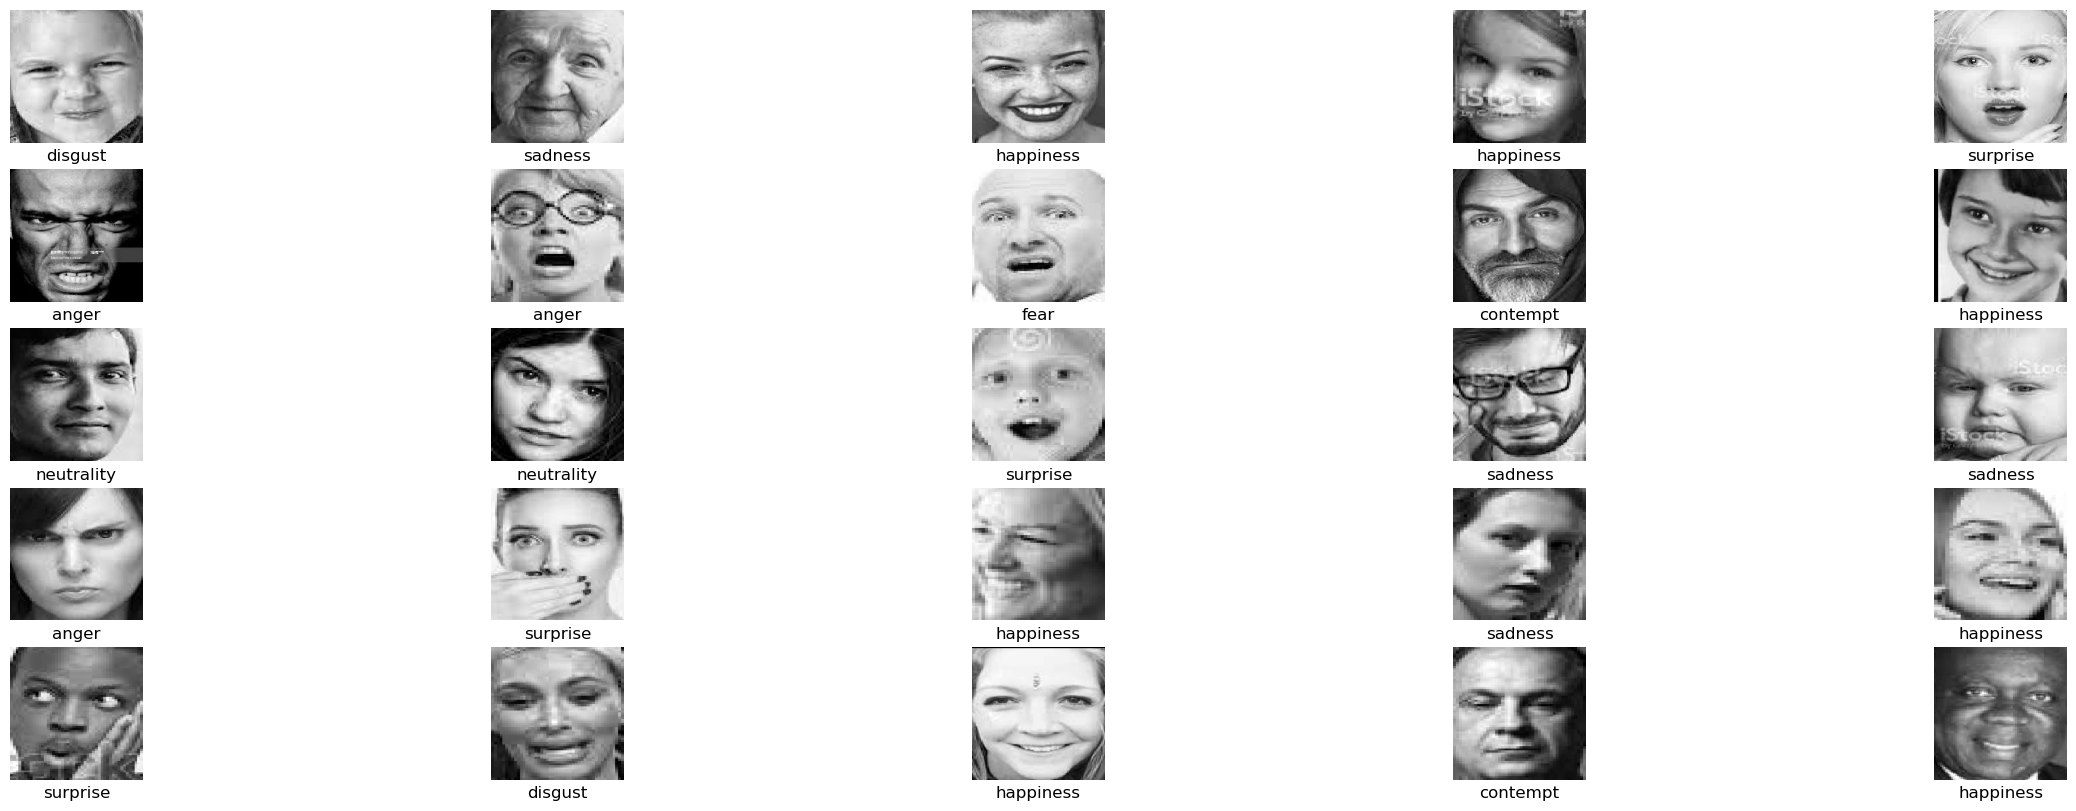

In [5]:
plt.figure(figsize=(30, 10))
for i, ( image, label ) in zip(range(25), train_dataset.unbatch()):    
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[label], y=-0.20)
    plt.axis("off")
plt.show()

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 220
Number of test batches: 44


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05)
        , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
    ]
)

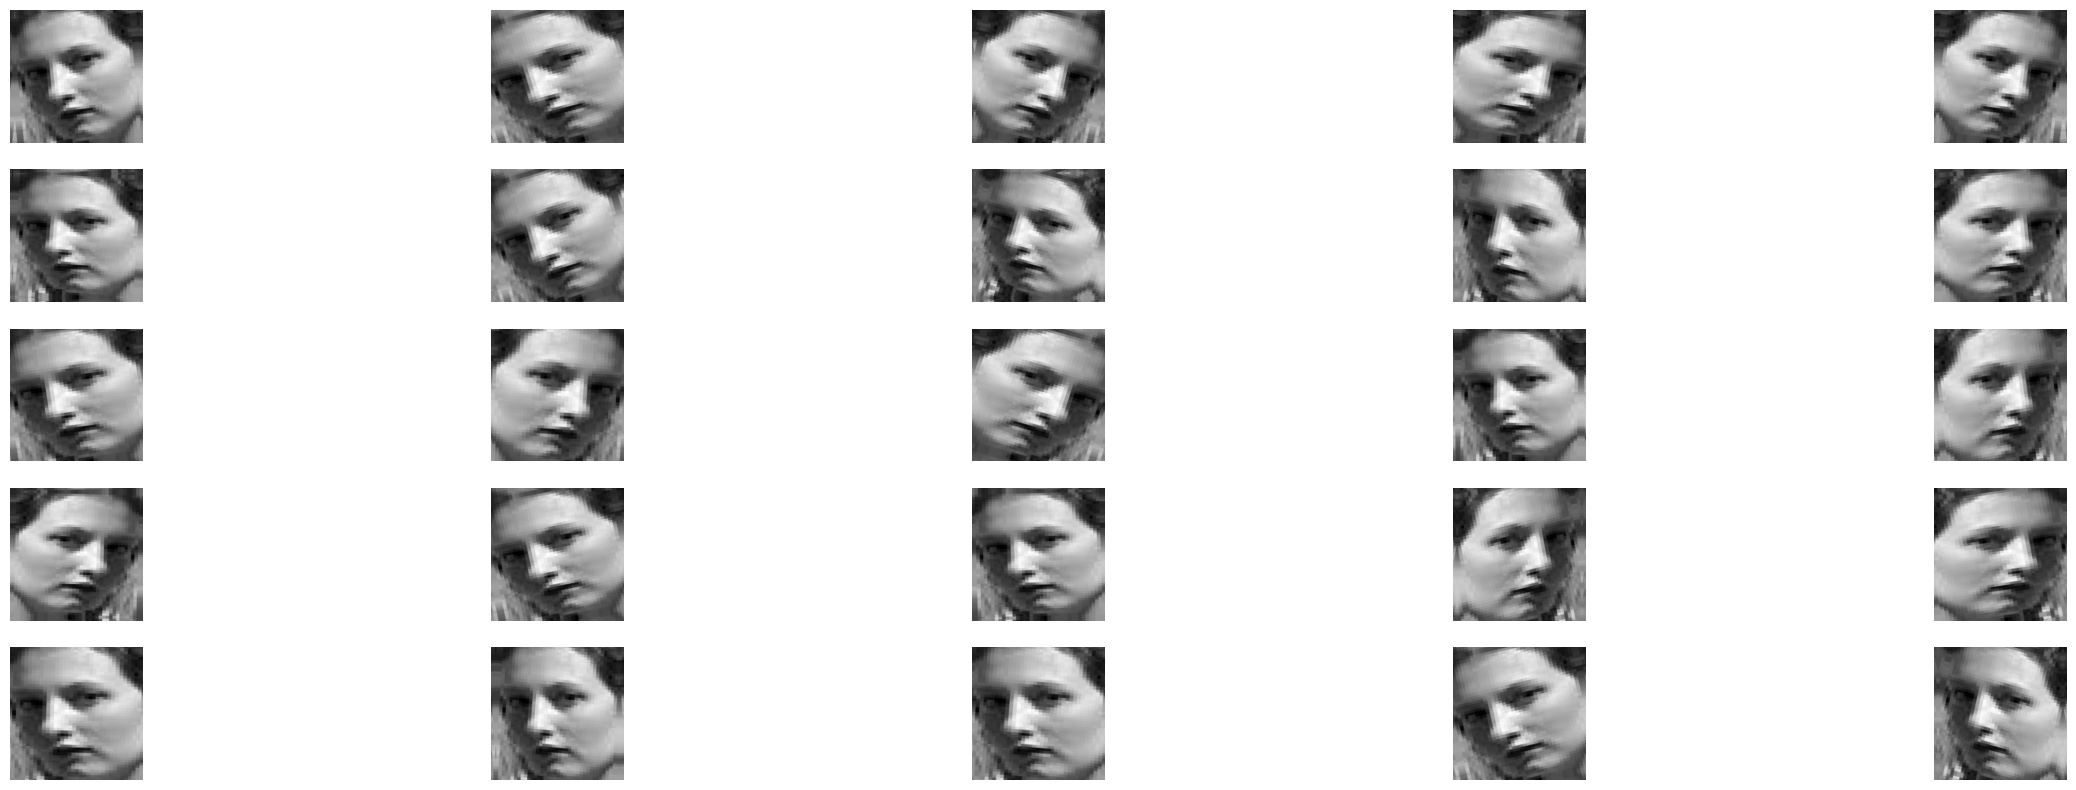

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# MODEL
input_shape = image.shape
print('INPUT SHAPE: ',  input_shape)
model = tf.keras.Sequential()
model.add(layers.Input(shape=input_shape))

model.add(layers.Conv2D(filters=5, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(filters=5, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=15, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Flatten())

model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

model.summary()

INPUT SHAPE:  (224, 224, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 5)       50        
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 5)      20        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 5)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 5)       230       
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 5)      20        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-10-30 16:56:09.766040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-30 16:56:10.337948: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(5, 9)


In [11]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

  1/220 [..............................] - ETA: 50s - loss: 185.7592 - accuracy: 0.0000e+00

/home/beldroega/anaconda3/envs/mc886-pf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


220/220 [==============================] - 3s 11ms/step - loss: 170.1093 - accuracy: 0.1177
initial loss: 170.11
initial accuracy: 0.12


In [13]:
initial_epochs = 15
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
877/877 [==============================] - 28s 30ms/step - loss: 3.1371 - accuracy: 0.2837 - val_loss: 2.5059 - val_accuracy: 0.2546
Epoch 2/15
877/877 [==============================] - 31s 35ms/step - loss: 0.8405 - accuracy: 0.7202 - val_loss: 2.8795 - val_accuracy: 0.2701
Epoch 3/15
877/877 [==============================] - 26s 30ms/step - loss: 0.3604 - accuracy: 0.9049 - val_loss: 2.4639 - val_accuracy: 0.4024
Epoch 4/15
877/877 [==============================] - 27s 31ms/step - loss: 0.2982 - accuracy: 0.9439 - val_loss: 3.1799 - val_accuracy: 0.3586
Epoch 5/15
877/877 [==============================] - 28s 32ms/step - loss: 0.2543 - accuracy: 0.9578 - val_loss: 4.1052 - val_accuracy: 0.2856
Epoch 6/15
877/877 [==============================] - 29s 33ms/step - loss: 0.3387 - accuracy: 0.9302 - val_loss: 3.9320 - val_accuracy: 0.3330
Epoch 7/15
877/877 [==============================] - 29s 33ms/step - loss: 0.2591 - accuracy: 0.9471 - val_loss: 3.9944 - val_accuracy:

In [14]:
# # Show the learning curves of the training and validation accuracy/loss
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()), 1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0, 1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [15]:
# # Fine tuning
# base_model.trainable = True
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 60

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Compile the model
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
#               metrics=['accuracy'])
# model.summary()

In [16]:
# len(model.trainable_variables) 

In [17]:
# # Continue training the model
# fine_tune_epochs = 30
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset)

In [18]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [19]:
# # Evaluation and prediction
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

# #Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch)
# print('pred', predictions)


# # Apply a sigmoid since our model returns logits
# predicted_class = np.argmax(predictions, axis=-1)

# print('Predictions:\n', predicted_class)
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image_batch[i].astype("uint8"))
#     plt.title(class_names[predicted_class[i]])
#     plt.axis("off")

In [20]:
# !pip install -q pyyaml h5py  # Required to save models in HDF5 format

# # SAVE
# model.save('tensorflow_model/saved_modelv3small')
# # model.save('saved_model/my_model.h5')
# # model.save_weights('saved_model/checkpoint')

In [21]:
#!source /opt/intel/openvino_2021/bin/setupvars.sh

In [22]:
#!python3 /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py --saved_model_dir ./tensorflow_model/saved_modelv3small --output_dir ./openvino_model/saved_modelv3small --input_shape [1,224,224,3]